In [2]:
from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
# importing all necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, Dense , Dropout,LSTM ,Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import os, pickle
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
df = pd.read_csv('/content/gdrive/MyDrive/IMDB Dataset.csv')

In [7]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
df.isnull()

,review,sentiment
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
49995,False,False
49996,False,False
49997,False,False
49998,False,False


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [10]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [11]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [12]:
values = list(df['sentiment'].value_counts().values)
key = list(df['sentiment'].value_counts().keys())

Text(0.5, 1.0, 'Balanced Dataset')

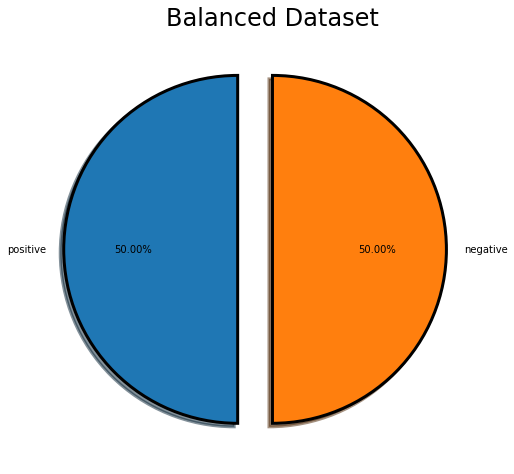

In [13]:
plt.figure(figsize=(8,8))
ex=[0.2,0]
plt.pie(values,labels=key,shadow=True,wedgeprops={'edgecolor':'k','lw':'3'},explode=ex,startangle=90,autopct='%1.2f%%')
plt.title("Balanced Dataset",fontsize=24)

In [14]:
max_len = (df['review'].map(len)).max()
max_len

13704

In [15]:
min_len = (df['review'].map(len)).min()
min_len

32

In [16]:
df['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [17]:
df['review'][6]

"I sure would like to see a resurrection of a up dated Seahunt series with the tech they have today it would bring back the kid excitement in me.I grew up on black and white TV and Seahunt with Gunsmoke were my hero's every week.You have my vote for a comeback of a new sea hunt.We need a change of pace in TV and this would work for a world of under water adventure.Oh by the way thank you for an outlet like this to view many viewpoints about TV and the many movies.So any ole way I believe I've got what I wanna say.Would be nice to read some more plus points about sea hunt.If my rhymes would be 10 lines would you let me submit,or leave me out to be in doubt and have me to quit,If this is so then I must go so lets do it."

In [18]:
df['char_len'] = df['review'].map(len)

In [19]:
df.head()

,review,sentiment,char_len
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production. <br /><br />The...,positive,998
2,I thought this was a wonderful way to spend ti...,positive,926
3,Basically there's a family where a little boy ...,negative,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317


In [20]:
df.describe()

,char_len
count,50000.000000
mean,1309.431020
std,989.728014
min,32.000000
25%,699.000000
50%,970.000000
75%,1590.250000
max,13704.000000


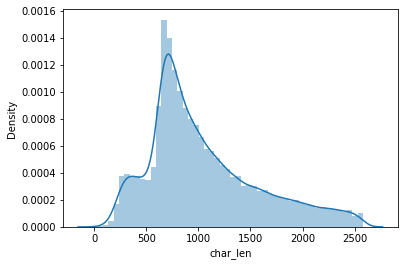

In [21]:
sns.distplot(df[df['char_len']<=df['char_len'].quantile(.90)]['char_len'])
plt.show()

In [22]:
new_df = df[df['char_len']<=df['char_len'].quantile(.90)]
new_df.head()

,review,sentiment,char_len
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production. <br /><br />The...,positive,998
2,I thought this was a wonderful way to spend ti...,positive,926
3,Basically there's a family where a little boy ...,negative,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317


In [23]:
new_df.shape

(45002, 3)

In [24]:
new_df = new_df[new_df['char_len']<=new_df['char_len'].median()]
df_2 = new_df[['review','sentiment']]
df_2.head()

,review,sentiment
3,Basically there's a family where a little boy ...,negative
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [25]:
df_2.shape

(22512, 2)

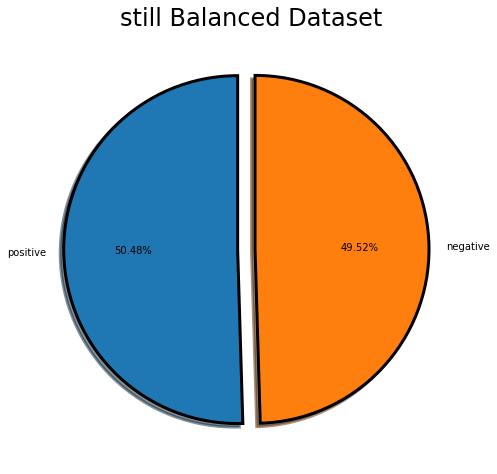

In [26]:
values = list(df_2['sentiment'].value_counts().values)
key = list(df_2['sentiment'].value_counts().keys())
plt.figure(figsize=(8,8))
ex = [0.1,0]
plt.pie(values,labels=key,shadow=True,wedgeprops={'edgecolor':'k','lw':'3'},explode=ex,startangle=90,autopct='%1.2f%%')
plt.title('still Balanced Dataset ',fontsize = 24)
plt.show()

In [27]:
df_2['sentiment'].value_counts()

positive    11363
negative    11149
Name: sentiment, dtype: int64

In [28]:
df_2 = df_2.reset_index().drop('index',axis =1)
df_2.head()

,review,sentiment
0,Basically there's a family where a little boy ...,negative
1,"Probably my all-time favorite movie, a story o...",positive
2,I sure would like to see a resurrection of a u...,positive
3,Encouraged by the positive comments about this...,negative
4,If you like original gut wrenching laughter yo...,positive


In [29]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [30]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [31]:
ps = PorterStemmer()
for i in range(len(df_2)):
  content = re.sub('[^a-zA-z]',' ',df_2['review'][i])
  content = content.lower()
  list_of_word = nltk.word_tokenize(content)
  removed_stopwords = [ps.stem(word) for word in list_of_word if word not in set(stopwords.words('english'))]
  df_2['review'][i] = ' '.join(removed_stopwords)

In [32]:
df_2.head()

,review,sentiment
0,basic famili littl boy jake think zombi closet...,negative
1,probabl time favorit movi stori selfless sacri...,positive
2,sure would like see resurrect date seahunt ser...,positive
3,encourag posit comment film look forward watch...,negative
4,like origin gut wrench laughter like movi youn...,positive


In [33]:
df_2['review'][0]

'basic famili littl boy jake think zombi closet parent fight time br br movi slower soap opera suddenli jake decid becom rambo kill zombi br br ok first go make film must decid thriller drama drama movi watchabl parent divorc argu like real life jake closet total ruin film expect see boogeyman similar movi instead watch drama meaningless thriller spot br br well play parent descent dialog shot jake ignor'

In [34]:
df_2['review'][2]

'sure would like see resurrect date seahunt seri tech today would bring back kid excit grew black white tv seahunt gunsmok hero everi week vote comeback new sea hunt need chang pace tv would work world water adventur oh way thank outlet like view mani viewpoint tv mani movi ole way believ got wan na say would nice read plu point sea hunt rhyme would line would let submit leav doubt quit must go let'

In [35]:
vocabulary_size=10000

In [36]:
#performing one hot encoding
one_hot_encode = [one_hot(reviw,vocabulary_size) for reviw in df_2['review']]
one_hot_encode

[[8572,
  6407,
  9305,
  9928,
  1626,
  8619,
  9838,
  1285,
  3164,
  3885,
  8632,
  3881,
  3881,
  399,
  4968,
  2439,
  6954,
  7378,
  1626,
  4417,
  3386,
  3217,
  594,
  9838,
  3881,
  3881,
  7788,
  7261,
  6479,
  6438,
  460,
  9774,
  4417,
  5355,
  6517,
  6517,
  399,
  68,
  3164,
  9003,
  2956,
  6851,
  2708,
  19,
  1626,
  1285,
  8557,
  5242,
  460,
  9342,
  8172,
  8842,
  4025,
  399,
  8168,
  9870,
  6517,
  8578,
  5355,
  4397,
  3881,
  3881,
  1539,
  5568,
  3164,
  8844,
  75,
  9169,
  1626,
  754],
 [669,
  8632,
  6989,
  399,
  4340,
  9754,
  5957,
  6095,
  970,
  5791,
  9760,
  8965,
  6975,
  2217,
  1703,
  87,
  5625,
  8632,
  8155,
  1667,
  1054,
  2528,
  3498,
  658,
  2677,
  2286,
  1873,
  3194,
  8490,
  8958,
  3178,
  3289,
  2758,
  2271,
  4912,
  2285,
  6851,
  9615,
  5854,
  9912,
  6438,
  6770,
  9870,
  7619,
  9048,
  9675,
  9789,
  5406,
  6789,
  9740,
  4068,
  3577,
  2957,
  399],
 [1962,
  2410,
  6851,
  

In [37]:
len(one_hot_encode),df_2.shape[0]

(22512, 22512)

In [38]:
rang = df_2['review'][0].split()
len(one_hot_encode[0]),len(rang)

(70, 70)

In [39]:
def max_len_word_sent(df):
  len_of_list = []
  for i in range(len(df)):
    lis_of_word = df['review'][i].split()
    len_of_list.append(len(lis_of_word))
  return(max(len_of_list))

In [40]:
max_review_len = max_len_word_sent(df_2)
max_review_len

110

In [41]:
df_3 = pad_sequences(one_hot_encode,padding='pre',maxlen=max_review_len)
df_3

array([[   0,    0,    0, ..., 9169, 1626,  754],
       [   0,    0,    0, ..., 3577, 2957,  399],
       [   0,    0,    0, ..., 9774, 6479,  342],
       ...,
       [   0,    0,    0, ...,  311, 3881, 3881],
       [   0,    0,    0, ..., 5280,  878, 5939],
       [   0,    0,    0, ..., 7914, 4613,  399]], dtype=int32)

In [42]:
len(df_3[258])

110

In [43]:
len(df_3)

22512

In [44]:
label_encode = dict(list(zip(list(df_2['sentiment'].value_counts().index),[1,0])))
label_encode

{'positive': 1, 'negative': 0}

In [45]:
y = df_2['sentiment'].map(label_encode)

In [46]:
y.value_counts()

1    11363
0    11149
Name: sentiment, dtype: int64

In [47]:
x = df_3
y=y

In [48]:
x.shape,y.shape

((22512, 110), (22512,))

In [49]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=42)


In [50]:
x_train,x_test,y_train,y_test

(array([[   0,    0,    0, ..., 2527, 7890, 7862],
        [   0,    0,    0, ..., 1667, 6528, 7275],
        [   0,    0,    0, ..., 4287,   96, 9531],
        ...,
        [   0,    0,    0, ..., 8942, 6300, 5750],
        [   0,    0,    0, ...,  667,  667, 2693],
        [   0,    0,    0, ..., 7676, 9294, 1787]], dtype=int32),
 array([[   0,    0,    0, ..., 6504, 7880, 3277],
        [   0,    0,    0, ..., 4663, 6590, 6185],
        [   0,    0,    0, ..., 3557, 5625,  460],
        ...,
        [   0,    0,    0, ..., 5757, 9408, 9488],
        [   0,    0,    0, ...,  101, 6232, 1030],
        [   0,    0,    0, ..., 1348, 5376, 4153]], dtype=int32),
 14193    1
 16150    1
 1983     1
 8900     1
 6544     1
         ..
 11964    1
 21575    1
 5390     0
 860      1
 15795    0
 Name: sentiment, Length: 16884, dtype: int64,
 19767    0
 13714    0
 11886    1
 15948    0
 13000    0
         ..
 11321    1
 2135     1
 21037    1
 6308     0
 11509    1
 Name: sentiment, Len

In [51]:
model  = Sequential()
model.add(Embedding(vocabulary_size,1000,input_length=max_review_len))
model.add(Dropout(0.5))
model.add(LSTM(units = 55))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer = 'adam',metrics=['accuracy'])

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 110, 1000)         10000000  
                                                                 
 dropout (Dropout)           (None, 110, 1000)         0         
                                                                 
 lstm (LSTM)                 (None, 55)                232320    
                                                                 
 dropout_1 (Dropout)         (None, 55)                0         
                                                                 
 dense (Dense)               (None, 1)                 56        
                                                                 
Total params: 10,232,376
Trainable params: 10,232,376
Non-trainable params: 0
_________________________________________________________________


In [53]:
model_history = model.fit(x_train,y_train,epochs=5,validation_data=(x_test,y_test))

Epoch 1/5
528/528 [==============================] - 48s 77ms/step - loss: 0.3897 - accuracy: 0.8284 - val_loss: 0.3163 - val_accuracy: 0.8623
Epoch 2/5
528/528 [==============================] - 12s 23ms/step - loss: 0.2290 - accuracy: 0.9128 - val_loss: 0.3308 - val_accuracy: 0.8715
Epoch 3/5
528/528 [==============================] - 10s 19ms/step - loss: 0.1656 - accuracy: 0.9396 - val_loss: 0.4016 - val_accuracy: 0.8612
Epoch 4/5
528/528 [==============================] - 10s 18ms/step - loss: 0.1184 - accuracy: 0.9577 - val_loss: 0.4292 - val_accuracy: 0.8602
Epoch 5/5
528/528 [==============================] - 8s 15ms/step - loss: 0.0784 - accuracy: 0.9733 - val_loss: 0.4833 - val_accuracy: 0.8518


<AxesSubplot:>

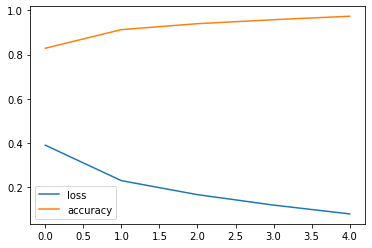

In [54]:
pd.DataFrame(model_history.history)[['loss','accuracy']].plot()

<AxesSubplot:>

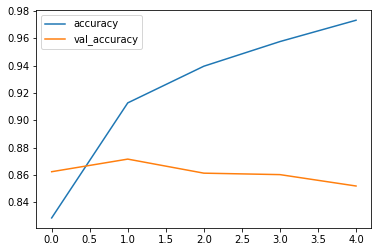

In [55]:
pd.DataFrame(model_history.history)[['accuracy','val_accuracy']].plot()

<AxesSubplot:>

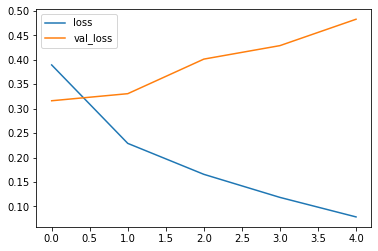

In [56]:
pd.DataFrame(model_history.history)[['loss','val_loss']].plot()

In [57]:
y_pred = model.predict(x_test)

176/176 [==============================] - 1s 4ms/step


In [58]:
y_pre = y_pred>0.5
y_pre

array([[False],
       [False],
       [ True],
       ...,
       [ True],
       [ True],
       [False]])

In [59]:
confusion_matrix(y_test,y_pre)

array([[2459,  394],
       [ 440, 2335]])

In [60]:
print(classification_report(y_test,y_pre))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      2853
           1       0.86      0.84      0.85      2775

    accuracy                           0.85      5628
   macro avg       0.85      0.85      0.85      5628
weighted avg       0.85      0.85      0.85      5628



In [61]:
y_test.values

array([0, 0, 1, ..., 1, 0, 1])

In [62]:
pred = pd.DataFrame(x_test)
pred['actual'] = y_test.values
pred['predicted'] = y_pre

In [63]:
pred.head(50)

,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,actual,predicted
0,0,0,0,0,0,0,0,0,0,0,...,9361,3444,1940,5876,8940,6504,7880,3277,0,False
1,0,0,0,0,0,0,0,0,0,0,...,3885,4554,8192,6364,2401,4663,6590,6185,0,False
2,0,0,0,0,0,0,0,0,0,0,...,5598,7141,915,4082,9774,3557,5625,460,1,True
3,0,0,0,0,0,0,0,0,0,0,...,1317,1049,4348,1688,9410,4417,4220,6438,0,False
4,0,0,0,0,0,0,0,0,0,0,...,6668,2557,7453,9011,8040,5985,863,8632,0,False
5,0,0,0,0,0,0,0,0,0,0,...,9014,7998,5641,2170,3373,545,2214,6918,0,False
6,0,0,0,0,0,0,0,0,0,0,...,6937,42,181,701,6479,5141,857,8731,1,True
7,0,0,0,0,0,0,0,0,0,0,...,3881,9410,1008,4663,6954,4072,4900,7759,1,True
8,0,0,0,0,0,0,0,0,0,0,...,9789,3984,6520,1169,4113,4698,9014,8158,0,False
9,0,0,0,0,0,0,0,0,0,0,...,2043,1564,4340,7570,7765,9636,3881,3881,0,False
